# Thunderbird 2 supercomputer logs EDA

## Introduction
This notebook contains exploratory data analysis of Thunderbird 2 supercomputer logs that is a part of CFDR data (see https://www.usenix.org/cfdr-data). CFDR data contains logs of 22 high-performance computing systems. The workloads run on those systems are large-scale long-running 3D scientific simulations, e.g. for nuclear stockpile stewardship. 

Original dataset used for extracting the sample under analysis is a raw text file containing event logs collected between 2004 and 2006 containing alert and non-alert messages identified by alert category tags. Thunderbird supercomputer logs dataset is suitable for alert detection and prediction research.

## The data set overview
Thunderbird original logs contain 211,212,192 messages, where 3,248,239 of them are related to 10 categories of alerts.  Non-alert messages are starting with "-" mark.

The logs were collected using UDP protocol for transmission. Some alert messages are missing in sample records that was caused by network connection interruption.

The data sample used for further analysis is extracted from the original one as a random subsample containing 0,5% of records.

More detailed dataset description can be found in the paper written by Adam Oliner and Jon Stearley [1].

## References
1. Oliner, Adam & Stearley, Jon. (2007). What Supercomputers Say: A Study of Five System Logs. 575-584. 10.1109/DSN.2007.103. 


# Exploratory data analysis

## I. The dataset overview and preprocessing



Load the dataset:

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import featuretools as ft
import gc
import numpy as np
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv("../data/tbird2_sample.csv")
data.head()

,alert_class,message_id,date,host_name,month,day,time,host_privilege,tool,message
0,-,1136327431,2006.01.03,an922,Jan,3,14:30:31,an922/an922,smartd[1976]:,Configuration file /etc/smartd.conf parsed.
1,-,1135346286,2005.12.23,dn669,Dec,23,05:58:06,dn669/dn669,crond[1281]:,(root) CMD (run-parts /etc/cron.hourly)
2,-,1136415929,2006.01.04,bn948,Jan,4,15:05:29,bn948/bn948,kernel:,Probing IDE interface ide4...
3,-,1134356625,2005.12.11,an212,Dec,11,19:03:45,an212/an212,Server,Administrator: Instrumentation Service EventID...
4,-,1135321264,2005.12.22,an23,Dec,22,23:01:04,an23/an23,crond(pam_unix)[6624]:,session closed for user root


In [19]:
data.shape

(229667, 8)

Extract new static timestamp features from datetime and time columns:

In [2]:
data["date"] = pd.to_datetime(data["date"])
data["datetime"] = data['date'].astype(str).str.cat(data['time'].astype(str), sep=' ')
data["datetime"] = pd.to_datetime(data["datetime"])
data['unix_date'] = pd.DatetimeIndex(data['datetime']).astype(np.int64)/1000000
data['weekday'] = data['datetime'].dt.weekday
data.drop(['date'], 1, inplace=True)
data.drop(['month'], 1, inplace=True)
data.drop(['day'], 1, inplace=True)
data.drop(['time'], 1, inplace=True)
data.drop(['datetime'], 1, inplace=True)
data.head()

,alert_class,message_id,host_name,host_privilege,tool,message,unix_date,weekday
0,-,1136327431,an922,an922/an922,smartd[1976]:,Configuration file /etc/smartd.conf parsed.,1.136299e+12,1
1,-,1135346286,dn669,dn669/dn669,crond[1281]:,(root) CMD (run-parts /etc/cron.hourly),1.135317e+12,4
2,-,1136415929,bn948,bn948/bn948,kernel:,Probing IDE interface ide4...,1.136387e+12,2
3,-,1134356625,an212,an212/an212,Server,Administrator: Instrumentation Service EventID...,1.134328e+12,6
4,-,1135321264,an23,an23/an23,crond(pam_unix)[6624]:,session closed for user root,1.135292e+12,3


Investigate **tool** feature:

In [3]:
data['tool'].value_counts()

kernel:                                                 101826
ib_sm.x[24904]:                                          25099
Server                                                    8894
/apps/x86_64/system/ganglia-3.0.1/sbin/gmetad[1684]:      5074
dhcpd:                                                    4406
sysctl:                                                   3971
ib_sm.x[15679]:                                           2247
rc.sysinit:                                               1473
fsck:                                                     1459
logger:                                                   1097
dataeng:                                                  1024
VFS:                                                       837
kernel:\n                                                  639
pbs_mom:                                                   608
ntpd:                                                      572
mount:                                                 

Processes names are in the following forms:
1. ***process_name:***
2. ***process_name [process_id]:***
3. ***process_name(authentication_module) [process_id]:***


In [4]:
data['tool'] = data['tool'].apply(lambda x: x.replace(':', '').replace('\r\n', ''))
data['process_id'] = data['tool'].str.extract('.*\[(.*)\].*')
data['tool'] = data['tool'].str.replace(r"\[.*\]","") # delete process id from tool description
data['tool_name'] = data['tool'].str.replace(r"\(.*\)","")
data['authentication'] = data['tool'].str.extract('.*\((.*)\).*')
data.drop(['tool'], 1, inplace=True)

data.head()

,alert_class,message_id,host_name,host_privilege,message,unix_date,weekday,process_id,tool_name,authentication
0,-,1136327431,an922,an922/an922,Configuration file /etc/smartd.conf parsed.,1.136299e+12,1,1976,smartd,NaN
1,-,1135346286,dn669,dn669/dn669,(root) CMD (run-parts /etc/cron.hourly),1.135317e+12,4,1281,crond,NaN
2,-,1136415929,bn948,bn948/bn948,Probing IDE interface ide4...,1.136387e+12,2,NaN,kernel,NaN
3,-,1134356625,an212,an212/an212,Administrator: Instrumentation Service EventID...,1.134328e+12,6,NaN,Server,NaN
4,-,1135321264,an23,an23/an23,session closed for user root,1.135292e+12,3,6624,crond,pam_unix


In [5]:
data['tool_name'].value_counts()

kernel                                           101826
ib_sm.x                                           27677
crond                                             21174
sshd                                              10820
snmpd                                              9682
Server                                             8894
xinetd                                             7795
ntpd                                               7051
/apps/x86_64/system/ganglia-3.0.1/sbin/gmetad      5097
dhcpd                                              4406
sysctl                                             3971
sendmail                                           1883
smartd                                             1738
rc.sysinit                                         1473
fsck                                               1459
logger                                             1097
dataeng                                            1024
VFS                                             

In [6]:
data['authentication'].value_counts()

pam_unix    19552
1               1
Name: authentication, dtype: int64

Drop the columns that bring bias into the data. Even when the logs have several messages related to the same process id, some of log alets are corrupted or have missing value of the  process id. Message and process id values are informative only in the context of current dataset, so they need to be dropped out. Host privilige already contains information represented by the host name, so this feature also should be dropped out.

In [7]:
data.drop(['process_id'], 1, inplace=True)
data.drop(['message_id'], 1, inplace=True)
data.drop(['host_privilege'], 1, inplace=True)

## II. Missing entries overview

In [8]:
data.isnull().sum()

alert_class            0
host_name              0
message              850
unix_date              0
weekday                0
tool_name              0
authentication    210114
dtype: int64

850 entries have logs with lost messages. As the message was missing due to the connection failure, all missing values are going to be replaced with 'Connection failure' message.
210114 entries have logs with missing authentication value - it means that the session can be already running or closed, it is unclear because log messages generated by different tools have different signatures, so as we are unaware of the context, fill all missing authentication values as unknown.

In [9]:
data['message'].fillna("Connection failure", inplace = True)
data['authentication'].fillna("unknown", inplace = True)
data.isnull().sum()

alert_class       0
host_name         0
message           0
unix_date         0
weekday           0
tool_name         0
authentication    0
dtype: int64

In [ ]:
data['message'].value_counts()

In [ ]:
data['message'].value_counts() == 1

## III.  Feature encoding 


In [10]:
data.alert_class.value_counts()

-                 219653
R_VAPI              7705
R_MTT               2140
N_CALL_TR            146
R_SCSI1                8
N_NFS                  5
R_MPT                  4
R_EXT_FS_ABRT2         3
R_EXT_INODE2           1
R_EXT_FS_ABRT1         1
R_SCSI0                1
Name: alert_class, dtype: int64

The sample contains 219653 non-alert messages, that is the majority of records.
All other log types belong to different alert types.

Encode alert / non-alert classes as follows:

In [11]:
log_type_dict = {'-':0, '^(?!.*-).*$':1}

data['alert_class'] = data['alert_class'].replace(log_type_dict, regex=True)

data.alert_class.value_counts()

0    219653
1     10014
Name: alert_class, dtype: int64

In [12]:
# Categorical boolean mask
categorical_feature_mask = data.dtypes==object# filter categorical columns using mask and turn it into a list
categorical_cols = data.columns[categorical_feature_mask].tolist()

le = LabelEncoder()
data[categorical_cols] = data[categorical_cols].apply(lambda col: le.fit_transform(col))

data[categorical_cols].head(10)

,host_name,message,tool_name,authentication
0,951,6504,100,2
1,3928,24,24,2
2,2071,14157,53,2
3,163,6026,14,2
4,182,25828,24,1
5,562,19486,34,2
6,3599,860,53,2
7,693,20132,53,2
8,339,6011,14,2
9,4785,20800,43,2


## IV. Feature engineering

Lag feature from the timestamp

As the timestamp feature itself would likely not show the correct correlation between the extract variables affecting alert type of the message, the lag feature is extracted for the **alert_class** based on the alert type of the previous record. All 200,000 log records were intentionally extracted keeping the original order based on the timestamp from the raw dataset. The **t-1** lag feature for alert type is extracted as follows:

In [13]:
data = data.sort_values(by='unix_date')

In [14]:
data['lag_1'] = data['alert_class'].shift(1)
data.head()

,alert_class,host_name,message,unix_date,weekday,tool_name,authentication,lag_1
87384,0,2599,26107,1.131535e+12,2,73,2,NaN
122514,0,2606,10141,1.131535e+12,2,53,2,0.0
11996,0,2606,901,1.131535e+12,2,53,2,0.0
129534,0,2606,26196,1.131535e+12,2,53,2,0.0
144940,0,2,25839,1.131535e+12,2,104,1,0.0


In [15]:
data['lag_1'].fillna(0, inplace = True)
data['lag_1'].value_counts()

0.0    219653
1.0     10014
Name: lag_1, dtype: int64

In [48]:
data.drop(['unix_date'], 1, inplace=True)
data.head()

,alert_class,host_name,message,weekday,tool_name,authentication,lag_1
87384,0,2599,26107,2,73,2,0.0
122514,0,2606,10141,2,53,2,0.0
11996,0,2606,901,2,53,2,0.0
129534,0,2606,26196,2,53,2,0.0
144940,0,2,25839,2,104,1,0.0


## V. Features overview

Frequency distribution of alert and non-alert messages:

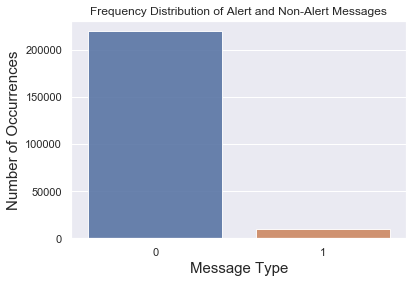

In [49]:
%matplotlib inline
count = data['alert_class'].value_counts()
sns.set(style="darkgrid")
sns.barplot(count.index, count.values, alpha=0.9)
plt.title('Frequency Distribution of Alert and Non-Alert Messages')
plt.ylabel('Number of Occurrences', fontsize=15)
plt.xlabel('Message Type', fontsize=15)
plt.show()

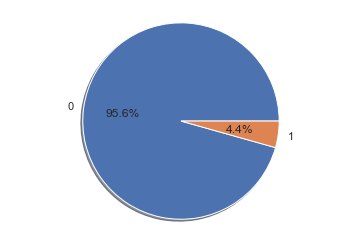

In [50]:
labels = data['alert_class'].astype('category').cat.categories.tolist()
counts = data['alert_class'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
plt.show()

As it is seen from the pie plot above, there are only 4,4% records that behave as anomalies.

Data distribution:

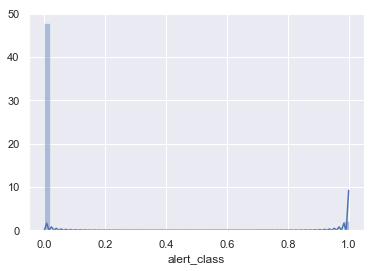

In [51]:
sns.set(color_codes=True)
sns.distplot(data['alert_class'])

## VI. Features correlation heatmap

Normality tests

In [33]:
data.shape

(229667, 8)

In [52]:
# Anderson-Darling Test

from scipy.stats import anderson

# normality test
features = data.columns.values
# print(features)

def check_normality(feature):
    result = anderson(data[feature].values)
    print(feature, ' Statistic: %.3f' % result.statistic)
    p = 0
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
        else:
            print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))
            
for fre in features:
    check_normality(fre)

alert_class  Statistic: 83819.547
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)
host_name  Statistic: 6517.258
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)
message  Statistic: 7012.981
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)
weekday  Statistic: 5860.495
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look norm

According to Anderson-Darling normality test, nor of the features have Gaussian-like distribution, so the correlation between features is going to be checked based on Spearman's correlation.

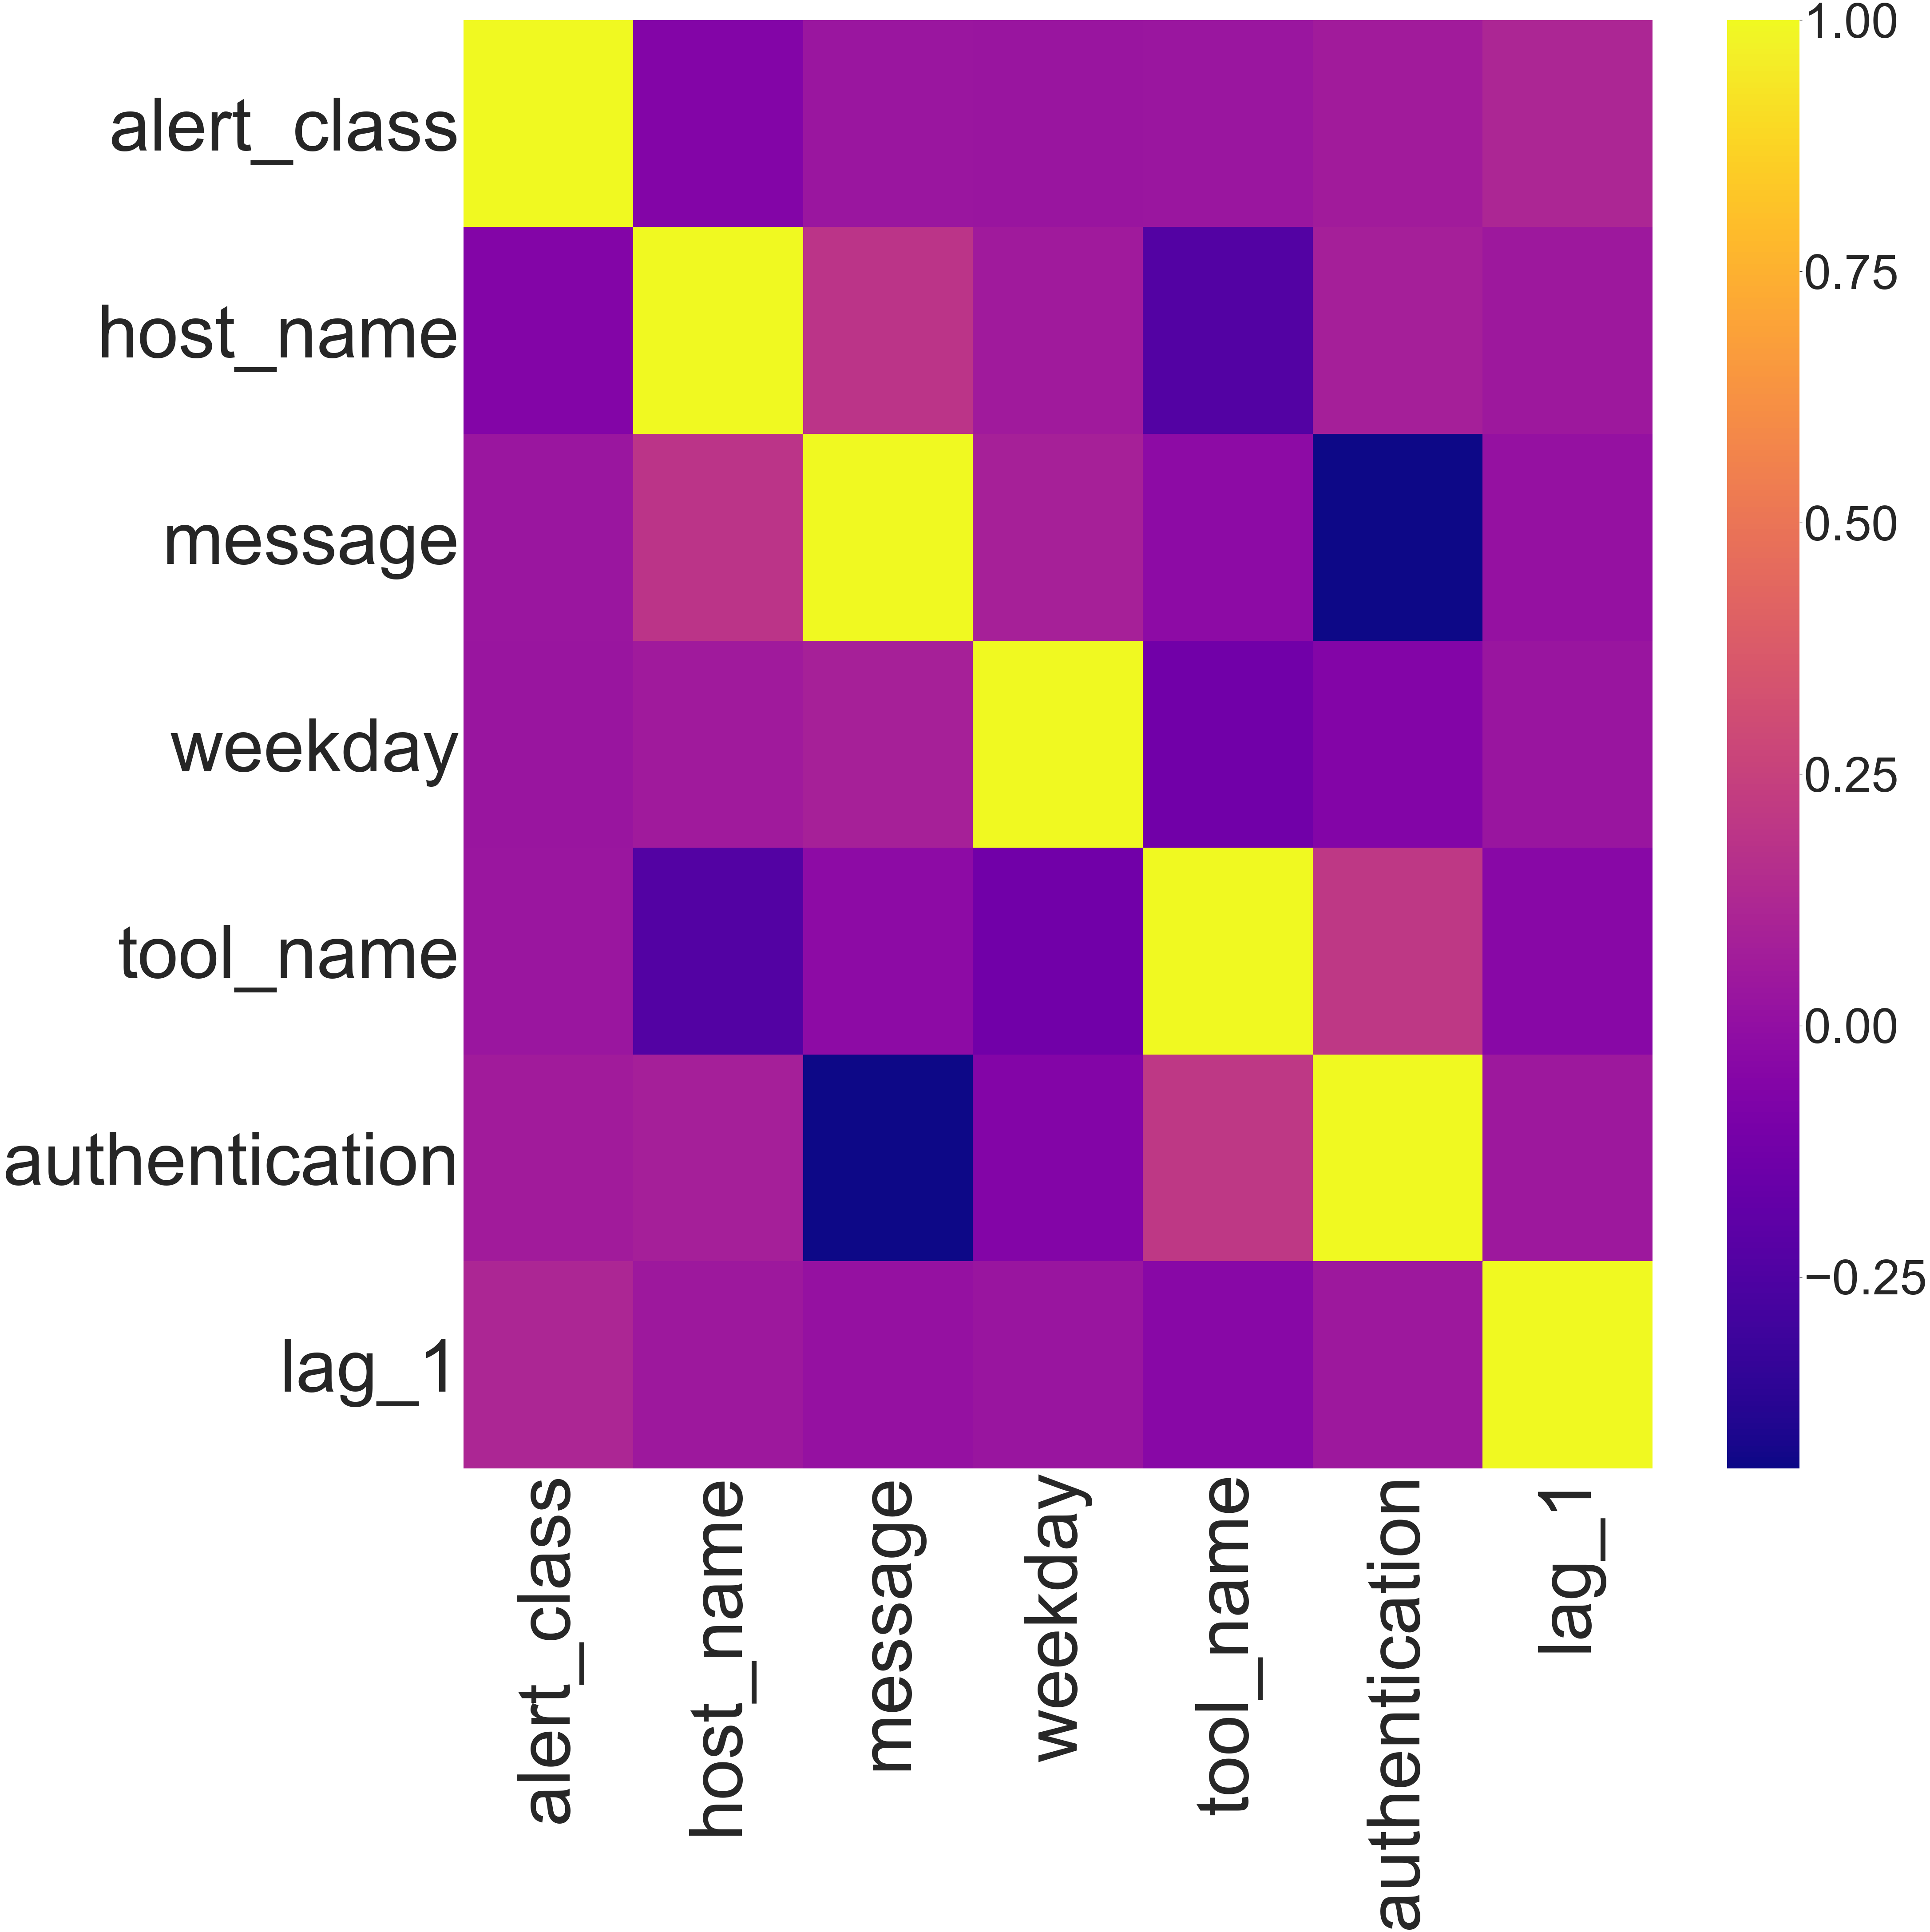

In [54]:
fig, ax = plt.subplots(figsize=(60, 60))
sns.set(font_scale=10)
correlation_matrix = data.corr(method='spearman', min_periods=1)
sns.heatmap(correlation_matrix, ax=ax, cmap="plasma", fmt="d")
ax.set_ylabel('')
ax.set_xlabel('')
plt.show()

As it is seen in the heatmap above, the majority of features have Spearman's correlation coefficient positive values close to 0, meaning that the majority of features are not linearly strongly correlated nor have strong negative linear correlation.
Authentication and message features currently have strongly negative correlation.

Features that are out of Spearman's linear correlation values range [0.0, 0.8] are going to be dropped out from the features set for reducing bias.


In [56]:
def drop_lin_correlated(df_in, method):
    lower_bound = 0.0
    upper_bound = 0.8
    corr_matrix = df_in.corr(method=method, min_periods=1).abs()
    # the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find indices of feature columns with correlation greater than 0.80
    features_above_max = [column for column in upper.columns if any(upper[column] > upper_bound)]
    # Find indices of feature columns with correlation less than 0
    features_below_min = [column for column in upper.columns if any(upper[column] < lower_bound)]
    features_to_drop = features_above_max + features_below_min
    df_out = df_in.drop(features_to_drop, axis=1)

    return df_out

filtered_out_features = drop_lin_correlated(data, method="spearman")
filtered_out_features.columns.values

array(['alert_class', 'host_name', 'message', 'weekday', 'tool_name',
       'authentication', 'lag_1'], dtype=object)

Currently all 7 features are kept